## Single parameter

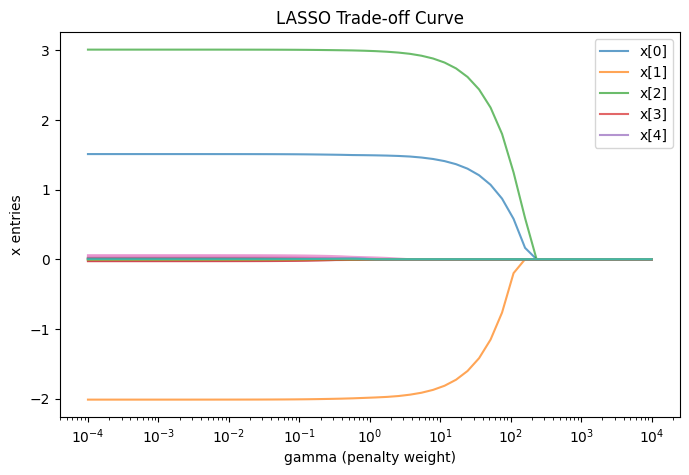

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
m, n = 50, 20
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:3] = [1.5, -2.0, 3.0]  # sparse true solution
b = A @ x_true + 0.1 * np.random.randn(m)

# Define optimization variables and parameters
x = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)

# Define problem
objective = cp.Minimize(cp.sum_squares(A @ x - b) + gamma * cp.norm1(x))
prob = cp.Problem(objective)

# Step 1: define a wide logarithmic grid
gamma_vals = np.logspace(-4, 4, 50)

# Step 2: solve for each gamma
x_solutions = []
for g in gamma_vals:
    gamma.value = g
    prob.solve()
    x_solutions.append(x.value)

x_solutions = np.array(x_solutions)

# Step 3: visualize trade-off curve
plt.figure(figsize=(8,5))
for i in range(n):
    plt.plot(gamma_vals, x_solutions[:, i], label=f"x[{i}]" if i < 5 else "", alpha=0.7)
plt.xscale("log")
plt.xlabel("gamma (penalty weight)")
plt.ylabel("x entries")
plt.title("LASSO Trade-off Curve")
plt.legend()
plt.show()


## Multiple parameters

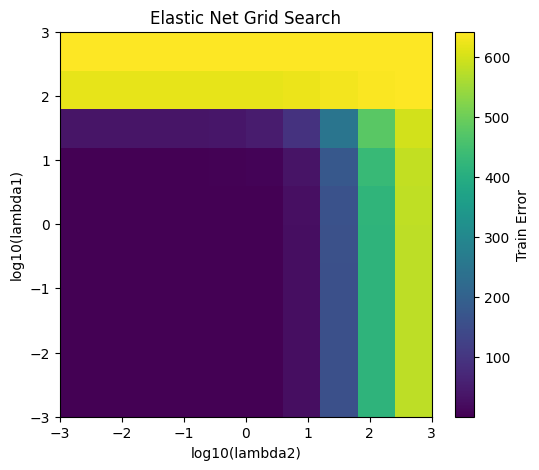

In [2]:
import cvxpy as cp
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(1)
m, n = 40, 15
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:3] = [2, -1.5, 3]  # sparse true solution
b = A @ x_true + 0.1 * np.random.randn(m)

# Variables and parameters
x = cp.Variable(n)
lambda1 = cp.Parameter(nonneg=True)
lambda2 = cp.Parameter(nonneg=True)

# Define Elastic Net objective
objective = cp.Minimize(cp.sum_squares(A @ x - b) +
                        lambda1 * cp.norm1(x) +
                        lambda2 * cp.sum_squares(x))
prob = cp.Problem(objective)

# Define search ranges (log-spaced grids)
lambda1_vals = np.logspace(-3, 3, 10)
lambda2_vals = np.logspace(-3, 3, 10)

# Store results
results = {}

# Grid search over (lambda1, lambda2)
for l1, l2 in itertools.product(lambda1_vals, lambda2_vals):
    lambda1.value = l1
    lambda2.value = l2
    prob.solve()
    results[(l1, l2)] = {
        "x": x.value.copy(),
        "obj": prob.value,
        "train_error": np.linalg.norm(A @ x.value - b)**2
    }

# Example: plot heatmap of training error across grid
errors = np.array([[results[(l1, l2)]["train_error"]
                    for l2 in lambda2_vals]
                   for l1 in lambda1_vals])

plt.figure(figsize=(6,5))
plt.imshow(errors, origin="lower", cmap="viridis",
           extent=[np.log10(lambda2_vals[0]), np.log10(lambda2_vals[-1]),
                   np.log10(lambda1_vals[0]), np.log10(lambda1_vals[-1])],
           aspect="auto")
plt.colorbar(label="Train Error")
plt.xlabel("log10(lambda2)")
plt.ylabel("log10(lambda1)")
plt.title("Elastic Net Grid Search")
plt.show()





## With cross-validation

Best λ1, λ2 = (np.float64(0.3727593720314938), np.float64(0.001))
Validation Error = 0.3685085984933468


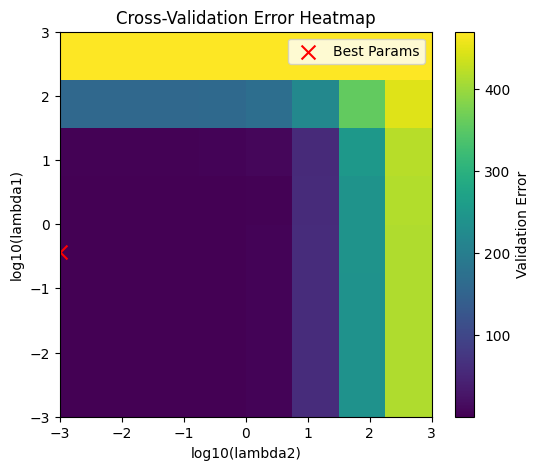

In [3]:
import cvxpy as cp
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate synthetic data
np.random.seed(1)
m, n = 80, 20
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:4] = [2.0, -1.5, 3.0, 1.0]  # sparse truth
b = A @ x_true + 0.1 * np.random.randn(m)

# Split train/validation
A_train, A_val, b_train, b_val = train_test_split(A, b, test_size=0.3, random_state=42)

# Variables and parameters
x = cp.Variable(n)
lambda1 = cp.Parameter(nonneg=True)
lambda2 = cp.Parameter(nonneg=True)

# Define Elastic Net objective (on training data)
objective = cp.Minimize(cp.sum_squares(A_train @ x - b_train) +
                        lambda1 * cp.norm1(x) +
                        lambda2 * cp.sum_squares(x))
prob = cp.Problem(objective)

# Define parameter grids (log-spaced)
lambda1_vals = np.logspace(-3, 3, 8)
lambda2_vals = np.logspace(-3, 3, 8)

# Store CV results
cv_results = {}

# Grid search
for l1, l2 in itertools.product(lambda1_vals, lambda2_vals):
    lambda1.value = l1
    lambda2.value = l2
    prob.solve()
    # Compute validation error
    val_error = np.linalg.norm(A_val @ x.value - b_val)**2
    cv_results[(l1, l2)] = {
        "x": x.value.copy(),
        "train_error": np.linalg.norm(A_train @ x.value - b_train)**2,
        "val_error": val_error,
        "objective": prob.value
    }

# Find best (lambda1, lambda2) by validation error
best_params = min(cv_results, key=lambda k: cv_results[k]["val_error"])
best_solution = cv_results[best_params]

print("Best λ1, λ2 =", best_params)
print("Validation Error =", best_solution["val_error"])

# Plot heatmap of validation error
errors = np.array([[cv_results[(l1, l2)]["val_error"]
                    for l2 in lambda2_vals]
                   for l1 in lambda1_vals])

plt.figure(figsize=(6,5))
plt.imshow(errors, origin="lower", cmap="viridis",
           extent=[np.log10(lambda2_vals[0]), np.log10(lambda2_vals[-1]),
                   np.log10(lambda1_vals[0]), np.log10(lambda1_vals[-1])],
           aspect="auto")
plt.colorbar(label="Validation Error")
plt.xlabel("log10(lambda2)")
plt.ylabel("log10(lambda1)")
plt.title("Cross-Validation Error Heatmap")
plt.scatter(np.log10(best_params[1]), np.log10(best_params[0]),
            color="red", marker="x", s=100, label="Best Params")
plt.legend()
plt.show()


## With Bayesian optimization / Random search

No BO libs found. Falling back to random search.
Random search finished. Best log10 params: 0.632, -5.962, val_mse=3.7299e-02
 best_log10_lambda1  best_log10_lambda2  best_lambda1  best_lambda2  val_mse_best  test_mse_best  train_obj_at_best
            0.63152           -5.962436      4.280754      0.000001      0.037299       0.037071          39.292873


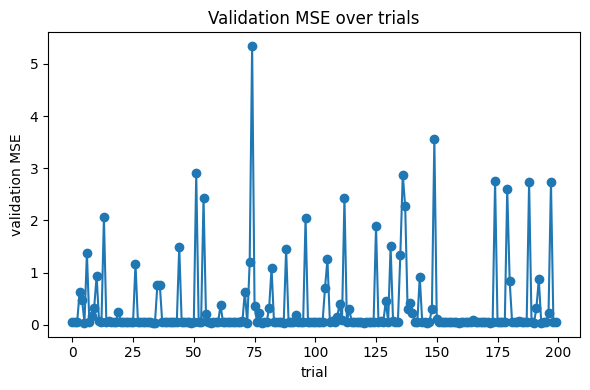

In [4]:
# bayes_opt_cvxpy_elasticnet.py
import numpy as np
import cvxpy as cp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import warnings
import pandas as pd

np.random.seed(0)
warnings.filterwarnings("ignore")

# -------------------- 1) synthetic data --------------------
m, n = 150, 30
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:5] = [2.5, -3.0, 1.5, 0.5, -1.0]
b = A @ x_true + 0.2 * np.random.randn(m)

# -------------------- 2) train/val/test split --------------------
A_temp, A_test, b_temp, b_test = train_test_split(A, b, test_size=0.2, random_state=1)
A_train, A_val, b_train, b_val = train_test_split(A_temp, b_temp, test_size=0.25, random_state=2)  # 60/20/20

# cvxpy problem setup (we will change lambda values via Parameters)
x = cp.Variable(n)
lambda1 = cp.Parameter(nonneg=True)  # L1 weight
lambda2 = cp.Parameter(nonneg=True)  # L2 weight

# training objective uses A_train, b_train
objective = cp.Minimize(cp.sum_squares(A_train @ x - b_train) + lambda1 * cp.norm1(x) + lambda2 * cp.sum_squares(x))
prob = cp.Problem(objective)

# helper: evaluate a given (lambda1, lambda2) on training -> fit x, return validation & test MSE
def evaluate_params(l1, l2, solver_priority=("OSQP", "SCS", None)):
    """Set lambda parameters, solve, and return (val_mse, test_mse, train_obj, x_hat)."""
    lambda1.value = l1
    lambda2.value = l2
    # Solve (try a preferred solver list)
    solved = False
    for s in solver_priority:
        try:
            if s is None:
                prob.solve(verbose=False)
            else:
                prob.solve(solver=getattr(cp, s), warm_start=True, verbose=False)
            solved = True
            break
        except Exception:
            continue
    if not solved:
        # last attempt with default
        prob.solve(verbose=False)
    x_hat = x.value
    val_mse = mean_squared_error(b_val, A_val @ x_hat)
    test_mse = mean_squared_error(b_test, A_test @ x_hat)
    train_obj = prob.value
    return float(val_mse), float(test_mse), float(train_obj), x_hat.copy()

# -------------------- 3) Bayesian optimization wrapper --------------------
log_min, log_max = -6, 2  # search range for log10(lambda)

def objective_log_space(log_params):
    """log_params: [log10_l1, log10_l2] -> returns validation MSE."""
    log_l1, log_l2 = log_params
    l1, l2 = 10.0**log_l1, 10.0**log_l2
    val_mse, _, _, _ = evaluate_params(l1, l2)
    return val_mse

history = []
best_l1 = best_l2 = None

# Try scikit-optimize
try:
    from skopt import gp_minimize
    from skopt.space import Real
    space = [Real(log_min, log_max, name="log_l1"), Real(log_min, log_max, name="log_l2")]
    print("Using scikit-optimize gp_minimize...")
    start_time = time.time()
    result = gp_minimize(objective_log_space, space, n_calls=40, random_state=0, n_initial_points=12, verbose=True)
    end_time = time.time()
    best_log = result.x
    best_val = result.fun
    history = list(zip(result.x_iters, result.func_vals))
    best_l1, best_l2 = 10**best_log[0], 10**best_log[1]
    print(f"Done in {end_time-start_time:.1f}s. Best log10 params: {best_log}, val_mse={best_val:.4e}")
except Exception:
    # Try optuna
    try:
        import optuna
        print("Using Optuna (TPE) for optimization...")
        def optuna_objective(trial):
            log_l1 = trial.suggest_float("log_l1", log_min, log_max)
            log_l2 = trial.suggest_float("log_l2", log_min, log_max)
            return objective_log_space([log_l1, log_l2])
        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=0))
        start_time = time.time()
        study.optimize(optuna_objective, n_trials=60, show_progress_bar=True)
        end_time = time.time()
        best = study.best_trial
        best_log = [best.params["log_l1"], best.params["log_l2"]]
        best_val = best.value
        best_l1, best_l2 = 10**best_log[0], 10**best_log[1]
        print(f"Done in {end_time-start_time:.1f}s. Best log10 params: {best_log}, val_mse={best_val:.4e}")
    except Exception:
        # Fallback to random search
        print("No BO libs found. Falling back to random search.")
        rng = np.random.RandomState(0)
        n_random = 200
        best_val = np.inf
        for i in range(n_random):
            log_l1 = rng.uniform(log_min, log_max)
            log_l2 = rng.uniform(log_min, log_max)
            l1, l2 = 10**log_l1, 10**log_l2
            val_mse, test_mse, _, _ = evaluate_params(l1, l2)
            history.append(((log_l1, log_l2), val_mse))
            if val_mse < best_val:
                best_val = val_mse
                best_l1, best_l2 = l1, l2
        print(f"Random search finished. Best log10 params: {np.log10(best_l1):.3f}, {np.log10(best_l2):.3f}, val_mse={best_val:.4e}")

# Final evaluation on the test set
final_val_mse, final_test_mse, final_train_obj, final_x = evaluate_params(best_l1, best_l2)

# Summary
import pandas as pd
summary = {
    "best_log10_lambda1": np.log10(best_l1),
    "best_log10_lambda2": np.log10(best_l2),
    "best_lambda1": best_l1,
    "best_lambda2": best_l2,
    "val_mse_best": final_val_mse,
    "test_mse_best": final_test_mse,
    "train_obj_at_best": final_train_obj
}
summary_df = pd.DataFrame([summary])
print(summary_df.to_string(index=False))

# (Optional) simple plot of validation MSE over trials (if history is available)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
if history and isinstance(history[0][0], (list, tuple)):
    vals = [h[1] for h in history if h[1] is not None]
    plt.plot(vals, marker='o', linestyle='-')
    plt.xlabel("trial")
    plt.ylabel("validation MSE")
    plt.title("Validation MSE over trials")
plt.tight_layout()
plt.show()
